In [131]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPool2D, Input, Flatten
import tensorflow as tf
import uuid
from importlib import reload

#### Preprocessing

In [132]:
# Define paths to the pictures
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [133]:
# Create a Tensorflow dataset of 300 images for each category (anchor/reference, positive, negative).
n_images = 300
anchor = tf.data.Dataset.list_files(ANC_PATH + "/*.jpg").take(n_images)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(n_images)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(n_images)


In [134]:
# zip function
a = [1,2,3]
b = [4,5,6]
list(zip(a,b))

[(1, 4), (2, 5), (3, 6)]

In [135]:
# create labels (positiv = 1, negativ = 0)
positives = tf.data.Dataset.zip(
    (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip(
    (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

In [136]:
# Merge negative and positive data points into one data set
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()

In [137]:
samples.next()

(b'data/anchor/91d1e23a-2eee-11ed-bf64-d6a168035f6b.jpg',
 b'data/positive/5097ab3e-30e6-11ed-b734-d6a168035f6b.jpg',
 1.0)

In [138]:
# Define functions for preprocessing the images and apply them to the dataset.
IMG_SIZE = 105
def preprocess(file_path: str, img_size: int = IMG_SIZE) -> np.ndarray:
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (img_size, img_size))
    img = img / 255.0
    return img

def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

data = data.map(preprocess_twin)

In [139]:
# Shuffle dataset (so that the positives and negatives are evenly distributed)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [140]:
# 70-30 train-test-split
train_data = data.take(round(len(data) * 0.7))
train_data_iter = train_data.batch(16)
train_data_iter = train_data_iter.prefetch(8)

test_data = data.skip(round(len(data)*0.7))
test_data_iter = test_data.batch(16)
test_data_iter = test_data_iter.prefetch(8)

#### Modell

In [141]:
# Defining the "twin CNNs"
def make_embedding(img_size: int = IMG_SIZE):
    inp = Input(shape=(img_size, img_size, 3))
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPool2D(64, (2, 2), padding="same")(c1)
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPool2D(64, (2, 2), padding="same")(c2)
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPool2D(64, (2, 2), padding="same")(c3)
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    return Model(inputs=[inp], outputs=[d1], name="embedding")

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 21, 21, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 18, 18, 128)       26

In [142]:
# Define own layer: Absolute distances between both vectors
class L1Dist(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [143]:
# Overall Model
def make_siamese_model(img_size: int = IMG_SIZE):

    # Achor
    input_image = Input(name="input_img", shape=(img_size, img_size, 3))
    # Validation
    validation_image = Input(name="validation_img", shape = (img_size,img_size,3))

    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation = "sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs = classifier, name = "SiameseNetwork")

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [144]:
# Loss-Function
binary_cross_loss = tf.losses.BinaryCrossentropy()

# Optimizer
opt = tf.keras.optimizers.Adam(1e-4)

In [145]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [146]:
samples.next()[2]

1.0

In [147]:
test_lst = ["a","b","c"]
test_lst[:2]

['a', 'b']

In [148]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training = True)
        loss = binary_cross_loss(y, yhat)

    
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [149]:
def train(data, EPOCHS):
    for epoch in range(1,EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [150]:
EPOCHS = 51

file_name = f"trained_models_105/siamesemodel_{n_images}_{EPOCHS}.h5"

if os.path.exists(file_name):
    print(f"The file name '{file_name}' already exists.")
else:
    """Nur ausführen, wenn das Modell trainiert werden soll. 
    Ansonsten das vortrainierte Netz verwenden (siehe Evaluation).
    """
    #train(train_data_iter, EPOCHS)
    #siamese_model.save(file_name)
    pass

### Evaluation

In [151]:
# Load parameters from the already trained model
model = tf.keras.models.load_model("/Users/pauld/github.com/ML-course-2023/Week_4/face_detection/trained_models_105/siamesemodel_300_50.h5", custom_objects = {"L1Dist": L1Dist, "BinaryCrossentropy": tf.losses.BinaryCrossentropy})
embedding_pre_trained = make_embedding()
embedding_pre_trained.set_weights(model.layers[2].get_weights())
siamese_model_pre_trained = make_siamese_model()
siamese_model_pre_trained.set_weights(model.get_weights())

In [152]:
NO_TEST_DATA = 85

# Transform test data
test_data_unzip = list(zip(*test_data.as_numpy_iterator()))

test_data_1 = np.concatenate(test_data_unzip[0]).reshape((NO_TEST_DATA,IMG_SIZE,IMG_SIZE,3))
test_data_2 = np.concatenate(test_data_unzip[1]).reshape((NO_TEST_DATA,IMG_SIZE,IMG_SIZE,3))
test_label = np.expand_dims(np.array(test_data_unzip[2]), axis = 1)

#### Evaluation auf einzelnen Datenpunkten

In [153]:
n_test = 4

test_pred = model.predict([test_data_1[:n_test], test_data_2[:n_test]]).flatten()

# True if probability > 0.5 (and False if p <= 0.5)
test_pred_bool = test_pred > 0.5
print(tuple(test_pred))
print(tuple(test_pred_bool))

1/1 [==============================] - 0s 373ms/step
(1.4630173e-07, 0.9998562, 4.2667322e-10, 5.2829907e-10)
(False, True, False, False)


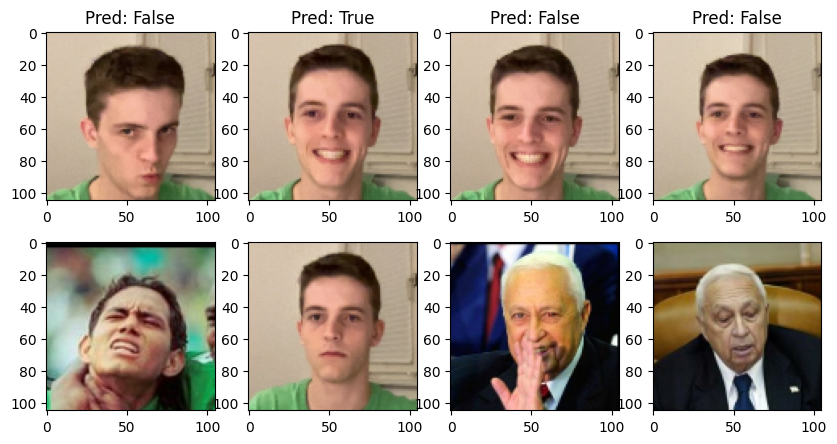

In [154]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 5))
for i in range(n_test):
    fig.add_subplot(2, n_test, i + 1)
    plt.imshow(test_data_1[i])
    plt.title(f"Pred: {bool(test_pred_bool[i])}")
for i in range(n_test):
    fig.add_subplot(2, n_test, i + 1 + n_test)
    plt.imshow(test_data_2[i])
plt.show()

#### Evaluation auf dem Gesamten Test-Datensatz

In [155]:
# Repetition: Accuracy describes the proportion of correct classifications in the total test data

 $accuracy = \frac{TP + TN}{TP + TN + FP + FN}$, TP = true positive,...

In [156]:
# Calculate predictions of all test data
pred = siamese_model_pre_trained.predict([test_data_1, test_data_2])
pred_bool = (pred > 0.5).astype(np.float32)

3/3 [==============================] - 6s 2s/step


In [157]:
# true positives und true negatives
tp_tn = len(test_data) - np.abs(test_label - pred_bool).sum()
accuracy = tp_tn / len(test_data)
print("Accuracy:", accuracy.round(4))

Accuracy: 0.9765


### Details

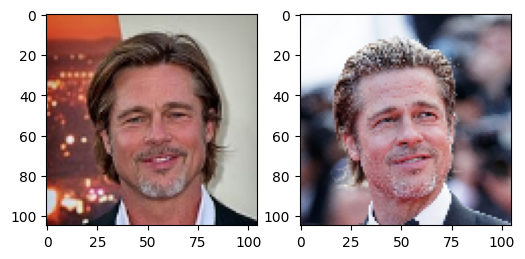

In [158]:
import image_generator
reload(image_generator)
from image_generator import read_image

fig = plt.figure(figsize=(6, 3))
#test_1 = test_data_1[2]
#test_2 = test_data_2[5]
test_1 = read_image("data/additional/Brad_Pitt_2019_by_Glenn_Francis.jpg")
#test_2 = test_1
test_2 = read_image("data/additional/3773139-2.jpg")
rand_lst = [test_1, test_2]
for i in range(len(rand_lst)):
    fig.add_subplot(1, len(rand_lst), i + 1)
    plt.imshow(rand_lst[i])
plt.show()

In [159]:
siamese_model_pre_trained.predict([test_1.reshape((1,IMG_SIZE,IMG_SIZE,3)), test_2.reshape((1,IMG_SIZE,IMG_SIZE,3))])

1/1 [==============================] - 0s 186ms/step


array([[0.9949524]], dtype=float32)

In [160]:
weights = siamese_model_pre_trained.layers[4].get_weights()[0]
bias = siamese_model_pre_trained.layers[4].get_weights()[1]
print("Bias in last layer:", bias[0])

Bias in last layer: 0.03501904


In [161]:
emb1 = embedding_pre_trained.predict(test_1.reshape((1,IMG_SIZE,IMG_SIZE,3)))
emb2 = embedding_pre_trained.predict(test_2.reshape((1,IMG_SIZE,IMG_SIZE,3)))

dist = L1Dist()(emb1, emb2)
dist.numpy()

1/1 [==============================] - 0s 151ms/step


array([[0.30350244, 0.10333079, 0.26273584, ..., 0.01424274, 0.06182598,
        0.09205115]], dtype=float32)

In [162]:
tf.sigmoid(np.matmul(np.array(dist), weights) + bias).numpy()

array([[0.9949524]], dtype=float32)